In [1]:
import numpy as np
import matplotlib.pylab as plt
import localcider
from localcider.sequenceParameters import SequenceParameters
from localcider import plots
import re
import os

In [2]:
cwd=os.getcwd()

In [14]:
# the proteins are from "Proteomics Clin. Appl. 2014, 8, 578–589",
#  For proteins that have multiple isoforms, only the isoform with SC > 10 are counted
# We also considered some extra genes like mypn, enh2 (pdlim5), myot, lmod2 etc
CoreProteins = ['actc1','actn2','mybpc3','myh6','myh7','myl2','myl3',\
                'myl7','tnnc1','tnni3','tnnt2','tpm1','tpm3','ttn']

AssoProteins = ["ablim1","ank2","capza2","crip3","cryab","ctnna1",\
                "des","fhl2","flnc","myom1","myoz2","nebl","obscn",\
                "sptb","synpo2","tgm2","tmod1"]

ExtraProteins = ['myot','lmod2','neb','mypn','enh2']



In [7]:
def readResult(gene,component='core',ponderDic='ponderResults',clinVarDic='clinVar',ptmDic='ptms'):
    """
    1) Read the outputs of ponder IDP prediction, the default 'VL-XT' predictor is used
    2) Read the clinVar "Pathogenic/Likely pathogenic" and identify those located in IDP regions
    3) Read the phosphorylation sites and identify those located in the IDP regions
    """
    pfile = os.path.join(cwd,ponderDic,component,gene)
    cfile = os.path.join(cwd,clinVarDic,component,gene)
    phosfile = os.path.join(cwd,ptmDic,component,gene)
    
    #ponder part
    with open(pfile,'r') as f:
        plines = f.readlines()
     
    flag=0
    idpSegs = []
    for i,j in enumerate(plines):
        strings = j.split()
        if "Predicted residues" in j:
            Nres = int(strings[2])           #total number of residues
            NidpRegion = int(strings[6])     # number of idp regions
        if "Number residues disordered" in j:
            NidpRes = int(strings[3])        # number of residues predicted to be IDP
            LidpRes = int(strings[7])        # number of residues in the longest IDP region
        if "Predicted disorder segment" in j:
            seg = re.findall(r'[0-9]+',strings[3])
            num = [int(i) for i in seg]
            idpSegs.append(num) 
    
    
     # clinVar part
    with open(cfile,'r') as f:
        lines = f.readlines()
        
    allMut = []
    for i in lines:
        if len(i) > 3:
               allMut.append(i.strip())
    
    idpMut = []
    for i in allMut:
        res = int(re.findall(r'[0-9]+',i)[0])
        for m,n in enumerate(idpSegs):
            if res <= n[1] and res >= n[0]:
                idpMut.append(res) 
        
    


    # phosphorylation part
    phosSite = []
    with open(phosfile) as f:
        lines = f.readlines()
        
    idpPhos = []    
    for i in lines:
        phosSite.append(i.strip())
        res = int(re.findall(r'[0-9]+',i)[0])
        for m,n in enumerate(idpSegs):
            if res <= n[1] and res >= n[0]:
                idpPhos.append(res) 
        
        

    data = {'Nres':Nres,   # total bumber of residues in the protein
           'NidpRes':NidpRes, # number of idp residues prediceted by ponder
           'NidpRegion':NidpRegion, # number of idp regions predicted by ponder
           'idpSegs':idpSegs, # specific residues in each idp region
           'allMut':allMut, # all disease mutations,
            'idpMut':idpMut, # disease mutations located in idp regions
            'phosSite':phosSite, #number of phosphorylation site
            'idpPhos':idpPhos} # number of phosphorylation site in the idp regions
    
    return data

In [8]:
def getIDPsequence(gene,data,component,ponderDic):
    """
    Read in the fasta for each predicted IDP region
    and the phosphorylated IDP sequence
    """
    fastafile =  os.path.join(cwd,ponderDic,component,gene)
    with open(fastafile) as f:
        lines = f.readlines()
        
    flag = 0
    fasta = []
    for i in lines:
        if i.startswith('Num') and 'VLXT' in i:
            flag = 1
            continue
        if flag == 1:
            if i[0].isdigit():
                fasta.append(i.split()[1])
    
    # If there are phosphorylation sites located in the idp regions, 
    # then change the phosphorylated reside to 'E' to mimic the effect of 
    # phosphorylation
    phosFasta = fasta.copy()
    for i in data['idpPhos']:
        phosFasta[i-1] = "E"
    
    
    idpSequencces = []
    idpPhosSequences = []
    for i in data['idpSegs']:
        frags = []
        phosFrags = []
        for j in range(i[0],i[1]+1):
            phosFrags.append(phosFasta[j-1])
            frags.append(fasta[j-1])
            
        idpSequencces.append("".join(frags))
        idpPhosSequences.append("".join(phosFrags))
    return idpSequencces, idpPhosSequences

In [16]:
def getFCR(gene,data,component='core',ponderDic='ponderResults'):
    """
    Using the localcider library to calculate the NFCR and PFCR (f_ and f+)
    
    """
    print (gene)
    idpSequence, idpPhosSequence = getIDPsequence(gene,data,component,ponderDic)
    
    ciderSeq = []
    ciderPhosSeq = []
    phosIdx = []
    k = -1
    for i in range(len(idpSequence)):
        if len(idpSequence[i]) >5: #only consider the idp frags that have >5 residues
            k += 1
            ciderSeq.append(SequenceParameters(idpSequence[i]))
            if idpSequence[i] != idpPhosSequence[i]:
            
                phosIdx.append(k)
                ciderPhosSeq.append(SequenceParameters(idpPhosSequence[i]))
                
    # calcualte the f+ and f_ and saved as x,y coords
    coords = []
    phosCoords = []
    for i in range(len(ciderSeq)):
        x, y = ciderSeq[i].get_fraction_positive(), ciderSeq[i].get_fraction_negative()
        coords.append([x,y])
    
    for i in range(len(ciderPhosSeq)):
        x1, y1 = ciderPhosSeq[i].get_fraction_positive(), ciderPhosSeq[i].get_fraction_negative()

        phosCoords.append([x1,y1])
        
    return [coords,phosCoords,phosIdx]
    

In [96]:
def plotPieChart(data,genename):
    """
    Polot the idp regions. The folded regions and idp regions are 
    interlaced
    """
    
    idpFrags = []
    noIdpFrags = []
    if len(data['idpSegs']) > 1:
        for i,j in enumerate(data['idpSegs']):
            if i == 0:
                if j[0] == 1:
                    idpsize = j[1] - j[0] + 1
                    noidpsize = 0
                else:
                    noidpsize = j[0]-1 
                    idpsize= 0
            else:
                #print (i)
                noidpsize = j[0] - data['idpSegs'][i-1][1] -1
                idpsize = j[1] - j[0] + 1
            
    
            idpFrags.append(idpsize)
            noIdpFrags.append(noidpsize)
    else:
        if data['idpSegs'][0][0] == 1:
            noIdpFrags = [0,data['Nres'] - data['idpSegs'][0][1] + 1]
            idpFrags = [data['NidpRes'],0]
        else:
            noIdpFrags = [data['idpSegs'][0][0],data['Nres']-data['idpSegs'][0][1]]
            idpFrags = [data['NidpRes'],0]
  
    if data['Nres'] - data['idpSegs'][-1][1] > 0:
        noIdpFrags.append(data['Nres'] - data['idpSegs'][-1][1]+1)
        idpFrags.append(0)
        
    aa = np.asarray(list(zip(noIdpFrags,idpFrags)))
    totalsize = list(aa.flatten())
    
    colors = []
    for i, j in enumerate(totalsize):
        if i % 2 == 0:
            colors.append('whitesmoke')
        else:
            colors.append('salmon')
            
    #plt.figure(figsize=(2,2),dpi=300)
    plt.pie(aa.flatten(),colors=colors)
    plt.plot([0,1],[0,0],lw=0.5,color='blue')
    #print (aa.flatten())
    plt.title("%s\n(%4.1f%%/%d/%d)" % (genename.upper(),(data['NidpRes']/data['Nres'])*100,\
                                                          len(data['idpMut']),len(data['idpPhos'])),\
                                                          fontsize=5)
    #plt.title("%5s %5.2f %3d %d" % (genename,data['NidpRes']/data['Nres'],\
                                                          #len(data['idpMut']),len(data['idpPhos'])),\
                                                          #fontsize=10,pad=-30)
        

In [104]:
def plotPappus(data,gene):
    """
    Plotting the IDPs on Puppus's phase diagram
    """
    #plt.figure(figsize=(1.5,1.5),dpi=200)
    #plt.subplot(2,1,1)
    alphaval = 0.1
    reg1, = plt.fill([0, 0, 0.25], [0, 0.25, 0],
                     color='Chartreuse', alpha=alphaval, zorder=1)
    reg2, = plt.fill([0, 0, 0.35, 0.25], [0.25, 0.35, 0, 0],
                     color='MediumSeaGreen', alpha=alphaval, zorder=1)
    reg3, = plt.fill([0, 0.325, 0.675, 0.35], [0.35, 0.675,
                                               0.325, 0], color='DarkGreen', alpha=alphaval, zorder=1)

    reg4, = plt.fill([0, 0, 0.325], [0.35, 1, 0.675],
                     color='Red', alpha=alphaval, zorder=1)

    reg5, = plt.fill([0.35, 0.675, 1], [0, 0.325, 0],
                     color='Blue', alpha=alphaval, zorder=1)

    # set the plot limits
    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])

    for i in data[0]:
        plt.scatter(i[0],i[1],color='black',s=1)
    
    for i in data[1]:
        plt.scatter(i[0],i[1],color='magenta',s=1)

    for m,n in enumerate(data[2]):

        plt.plot([data[0][n][0],data[1][m][0]],\
                 [data[0][n][1],data[1][m][1]],'--',lw=0.2,color="magenta")
    plt.title(gene.upper(),fontsize=5)
    plt.axis('off')

In [20]:
coreData = {i: readResult(i,component='core') for i in CoreProteins}
corePappu = {i: getFCR(i,coreData[i],component='core') for i in CoreProteins}


actc1
actn2
mybpc3
myh6
myh7
myl2
myl3
myl7
tnnc1
tnni3
tnnt2
tpm1
tpm3
ttn


In [21]:
AssoData = {i: readResult(i,component='associate') for i in AssoProteins}
AssoPappu = {i: getFCR(i,AssoData[i],component='associate') for i in AssoProteins}

ablim1
ank2
capza2
crip3
cryab
ctnna1
des
fhl2
flnc
myom1
myoz2
nebl
obscn
sptb
synpo2
tgm2
tmod1


In [22]:
extraData = {i: readResult(i,component='extraGenes') for i in ExtraProteins}
extraPappu = {i: getFCR(i,extraData[i],component='extraGenes') for i in ExtraProteins}

myot
lmod2
neb
mypn
enh2


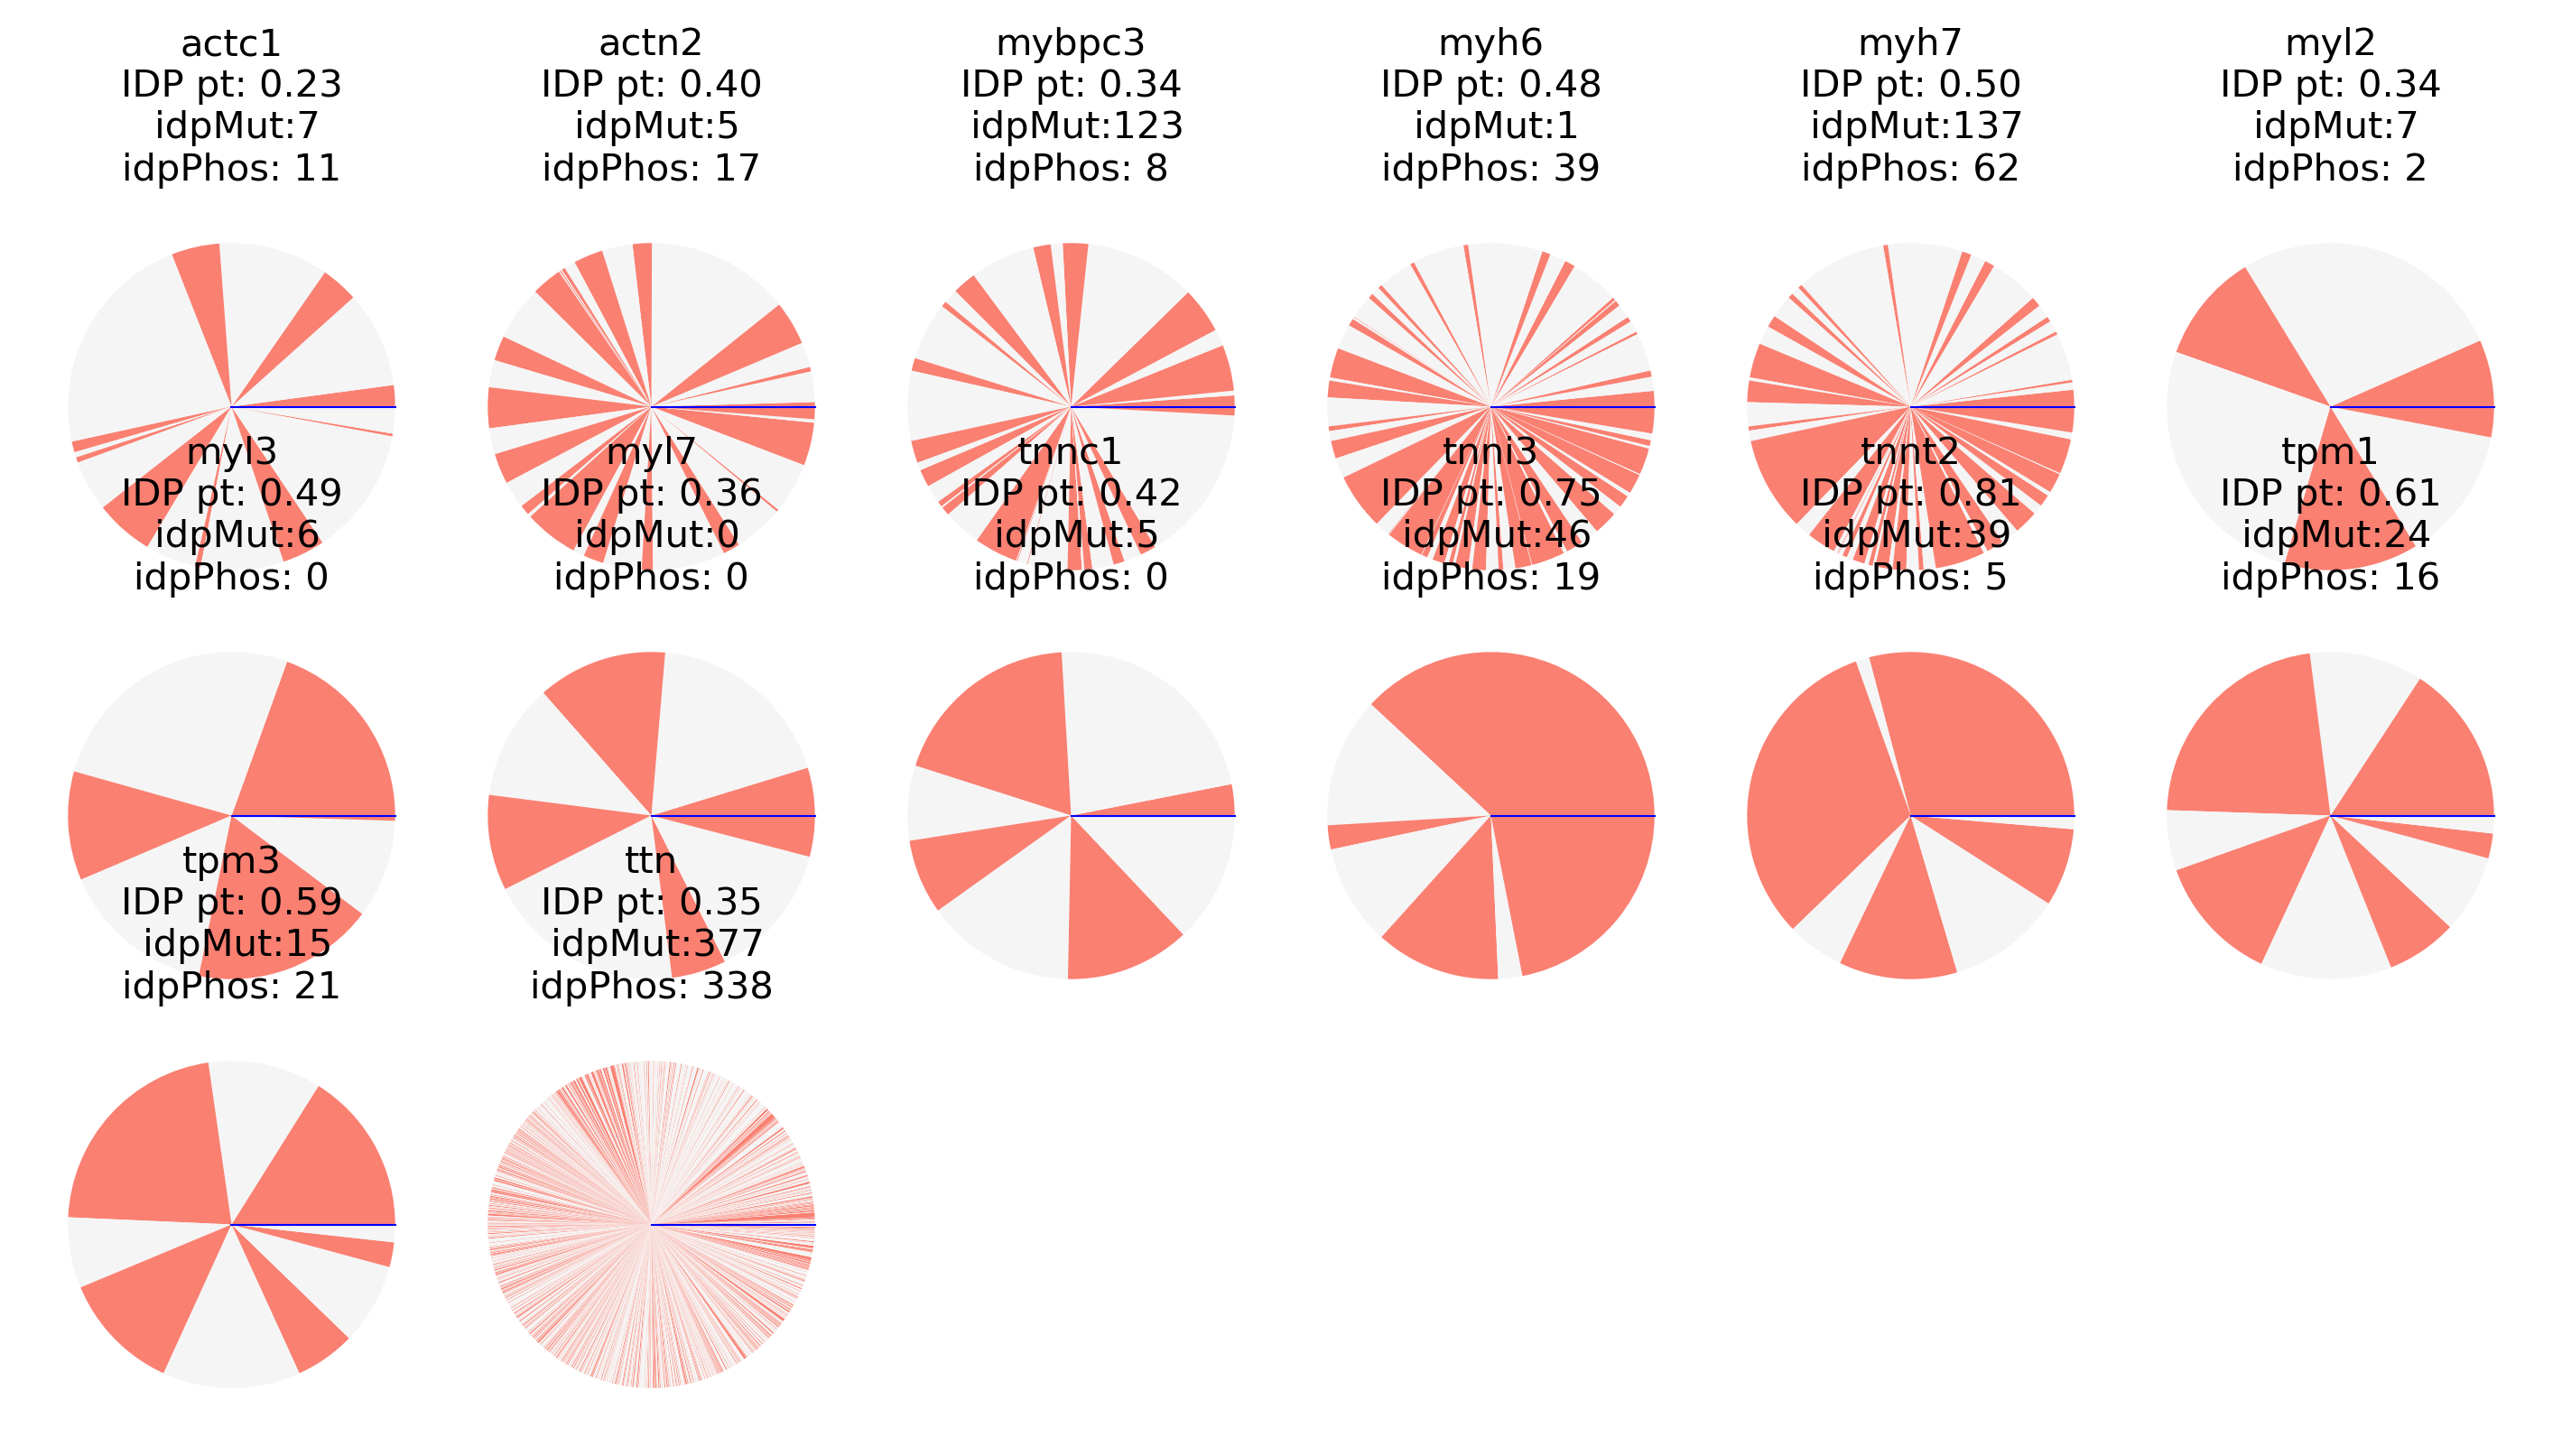

In [23]:
plt.figure(figsize=(12,6),dpi=300)
k=0
for i,j in coreData.items():
    k += 1
    plt.subplot(3,6,k)
    plotPieChart(coreData[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

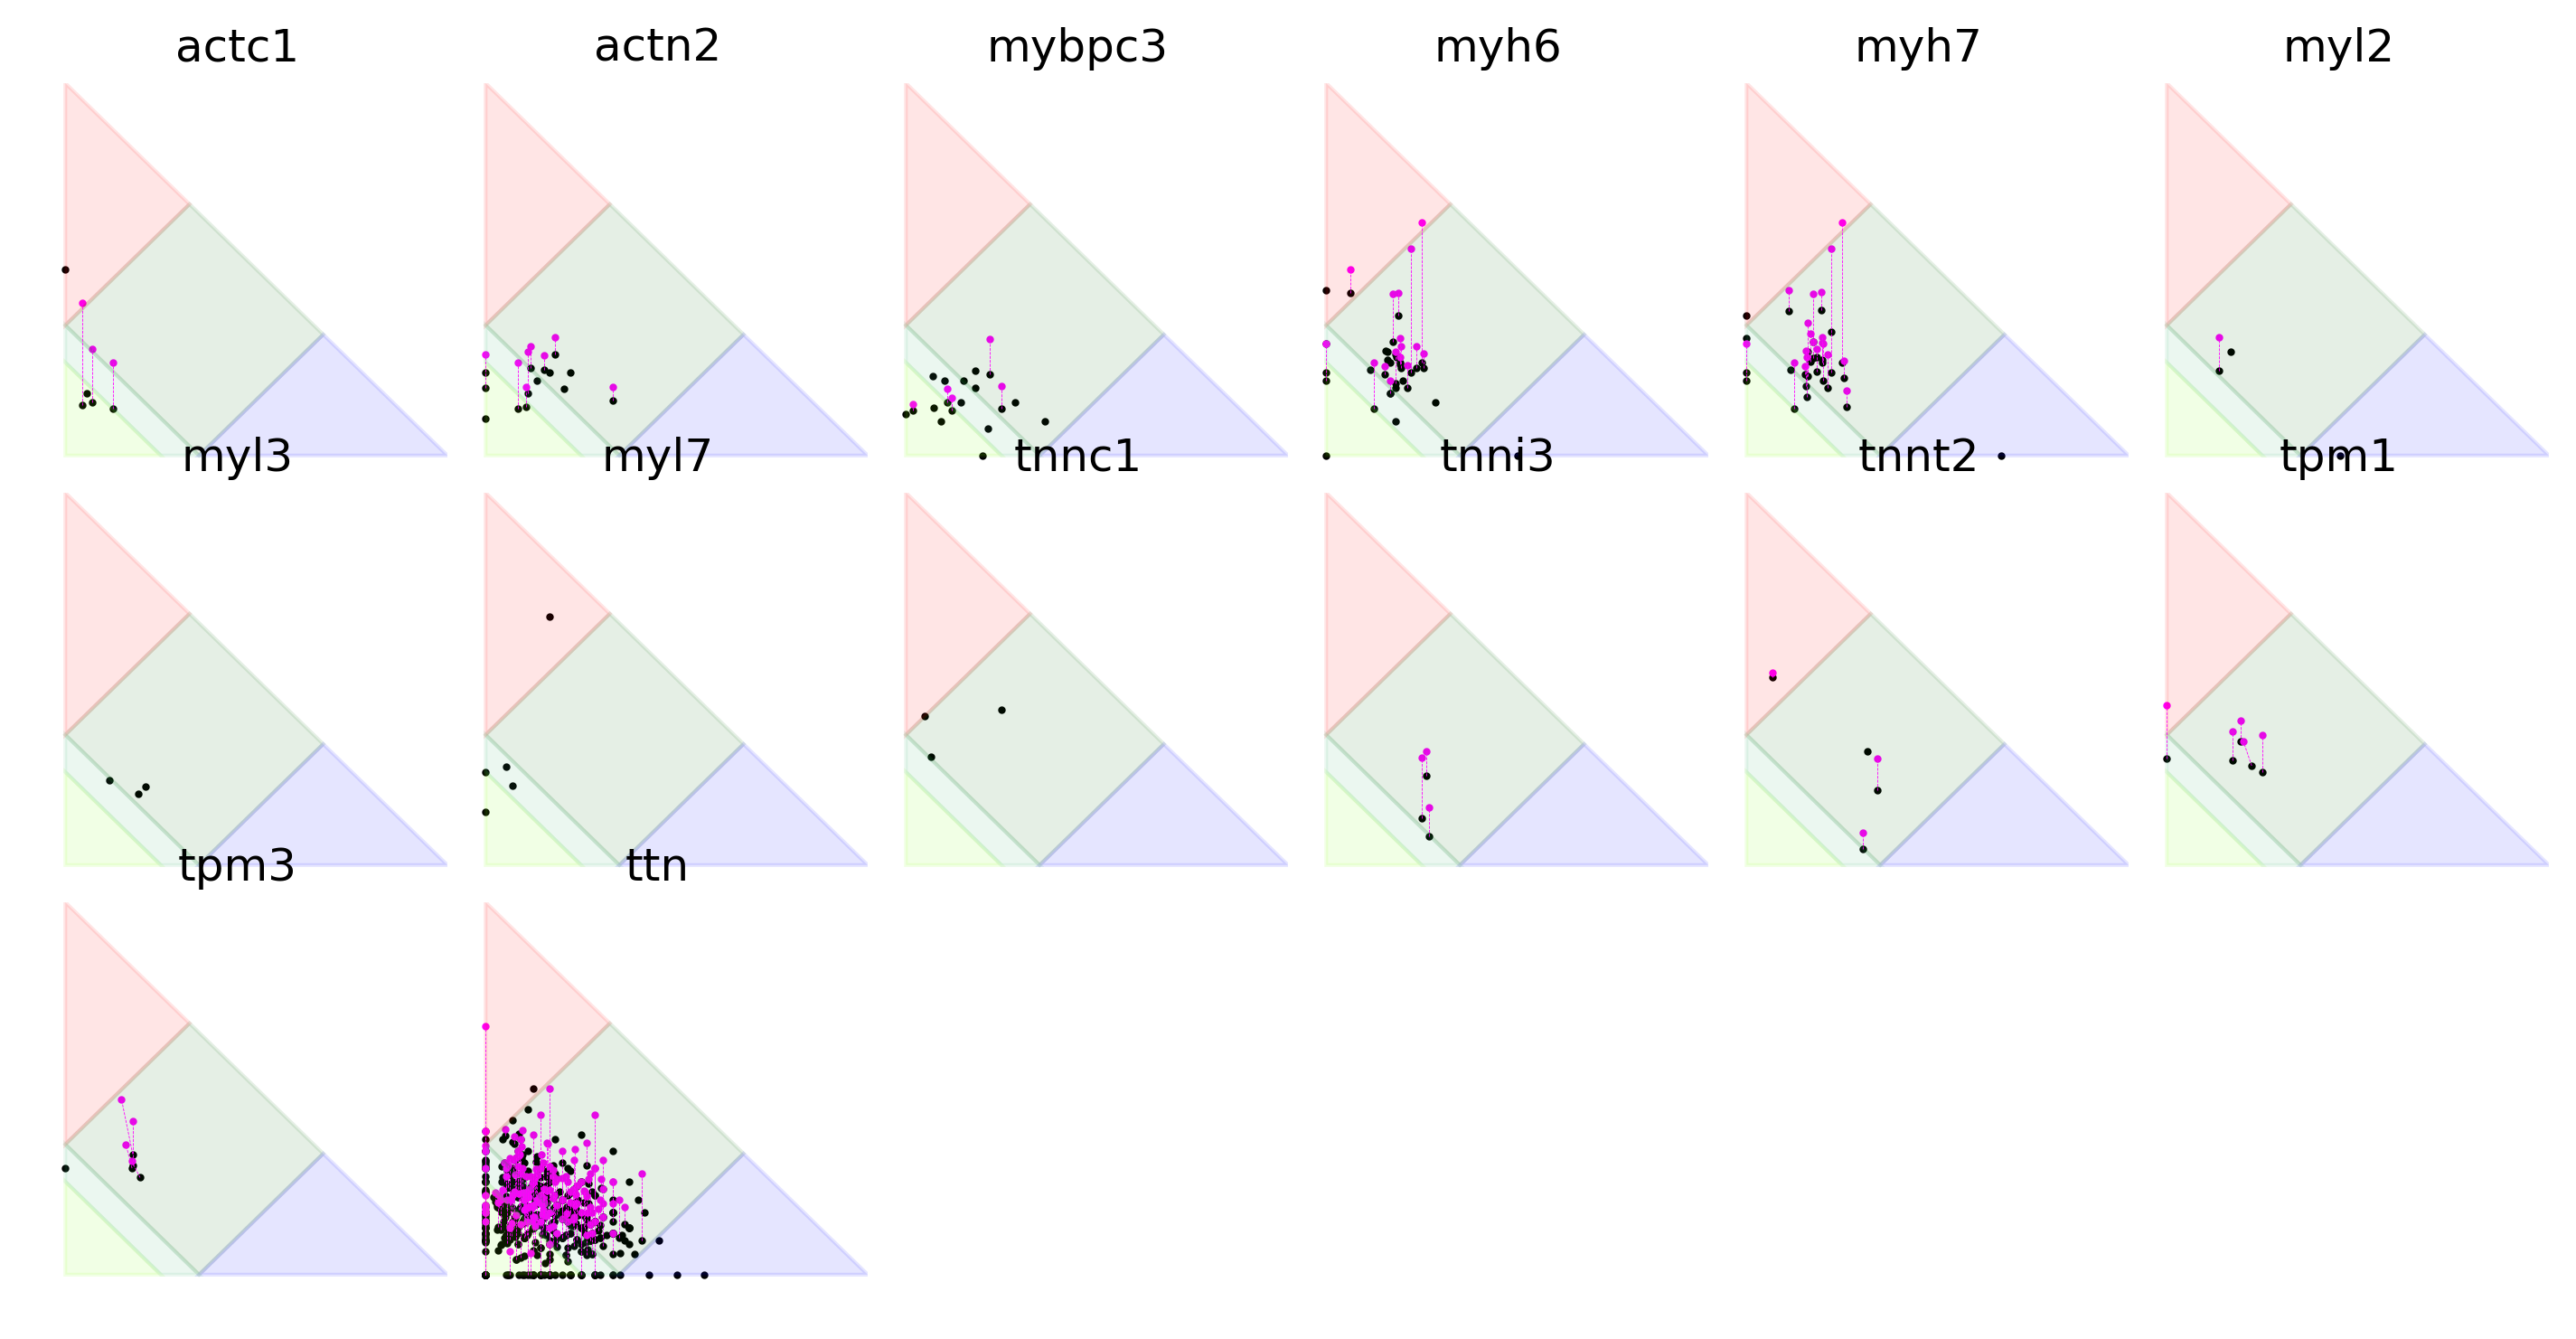

In [24]:
plt.figure(figsize=(12,6),dpi=300)
k=0
for i,j in corePappu.items():
    k += 1
    plt.subplot(3,6,k)
    plotPappus(corePappu[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

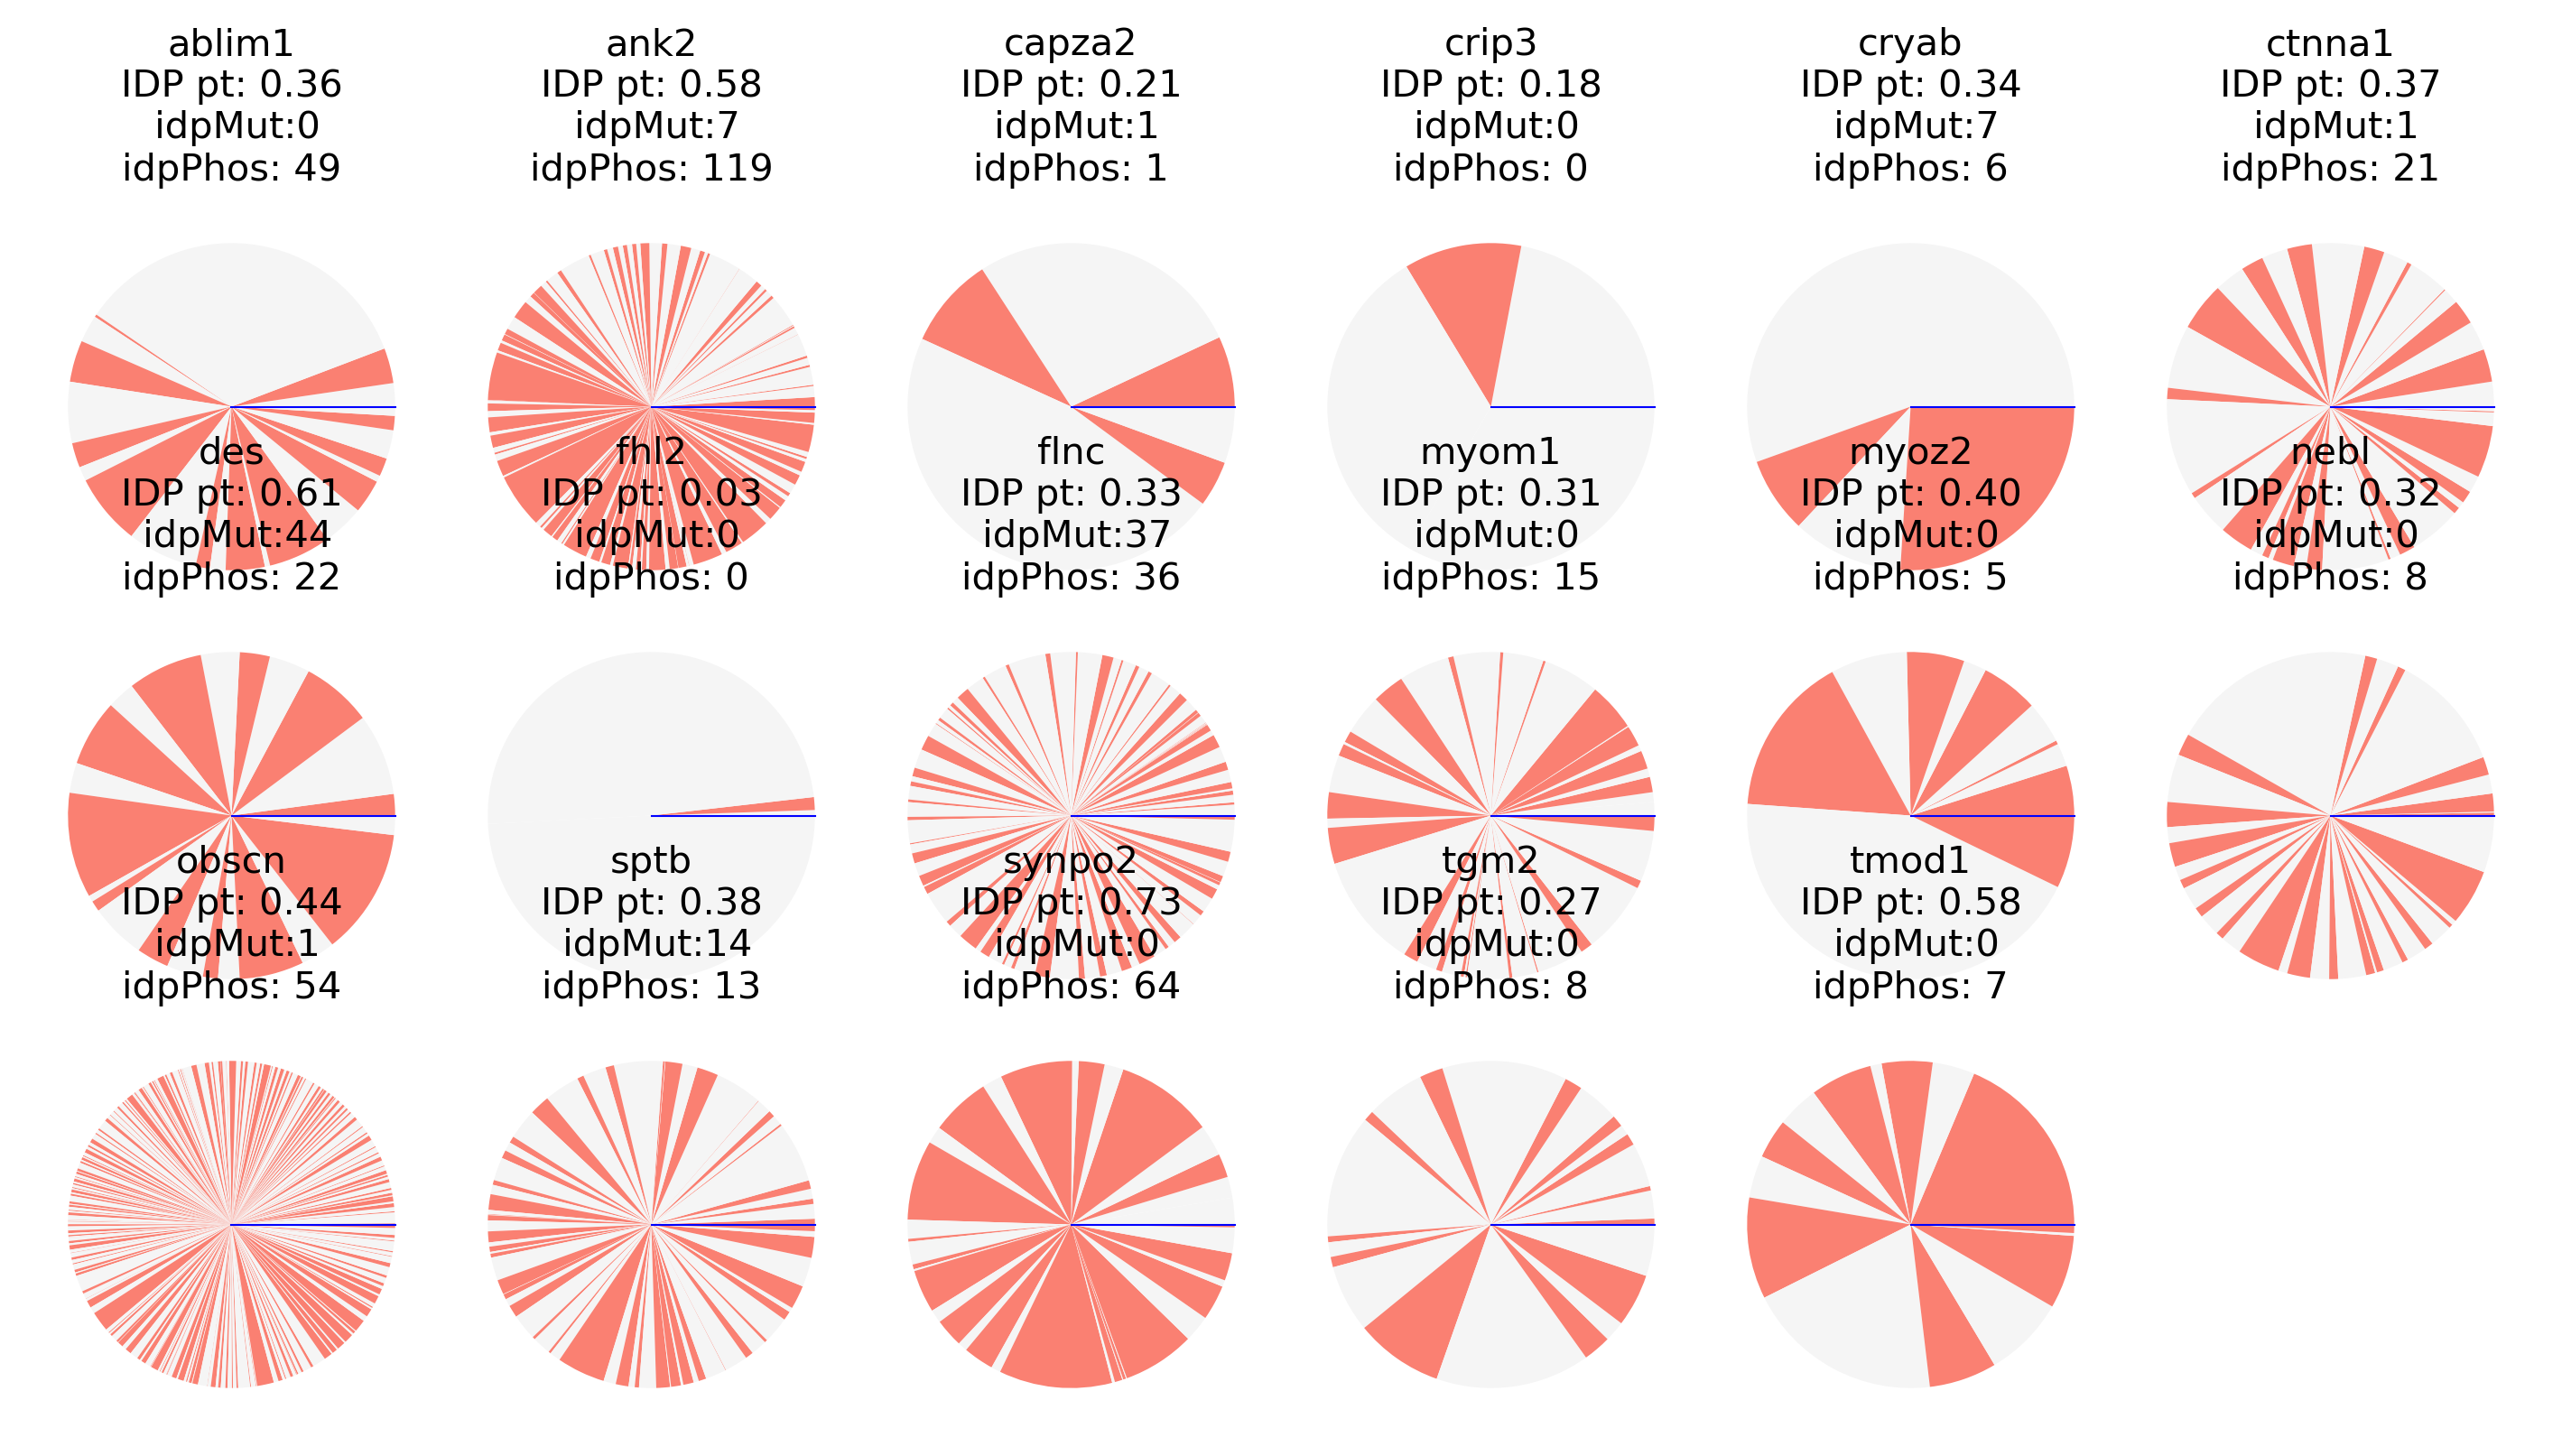

In [25]:
plt.figure(figsize=(12,6),dpi=300)
k=0
for i,j in AssoData.items():
    k += 1
    plt.subplot(3,6,k)
    plotPieChart(AssoData[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

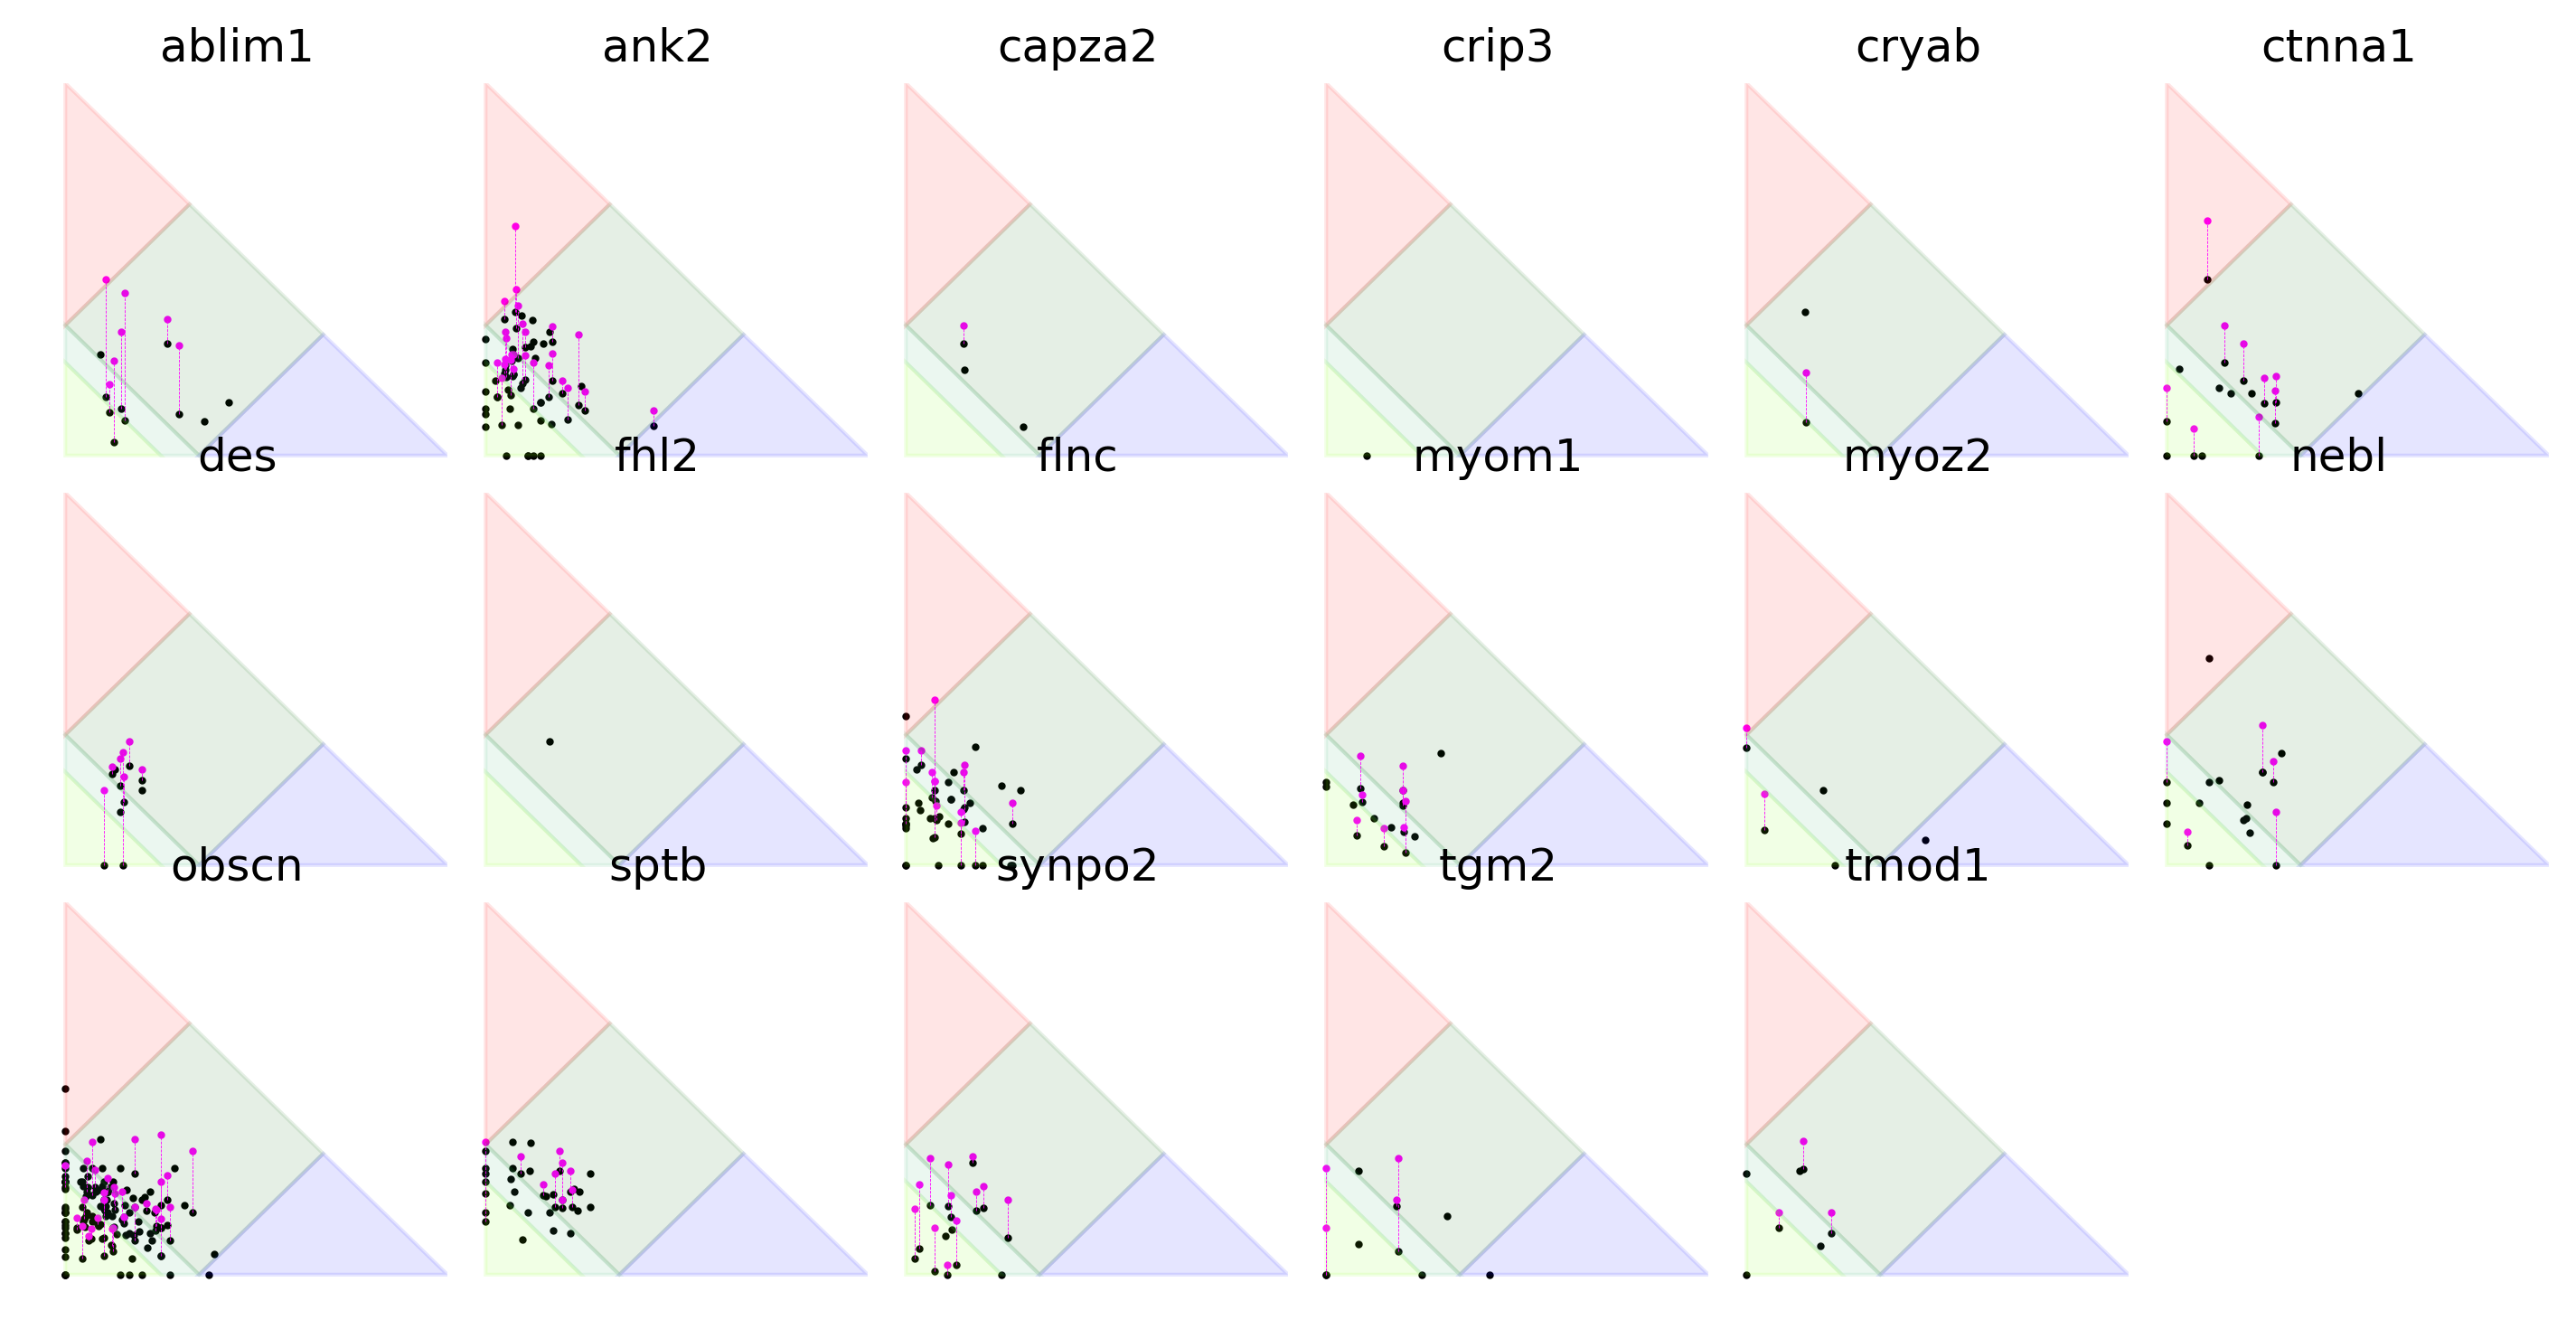

In [26]:
plt.figure(figsize=(12,6),dpi=300)
k=0
for i,j in AssoData.items():
    k += 1
    plt.subplot(3,6,k)
    plotPappus(AssoPappu[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

In [28]:
# We also categorize these genes into Thin, Thick filaments, Z-disk and actin-cross-linking

thinF = ['actc1','tnnc1','tnni3','tnnt2','tpm1','tpm3','tgm2','synpo2','tmod1','ablim1','ctnna1']
thickF = ['mybpc3','myh6','myh7','myl2','myl7','myl3','mypn','ttn']
zdisk = ['des','cryab','capza2','obscn','fhl2','nebl','neb','myot','enh2','myom1']
actinCross = ['ank2','crip3','actn2','flnc','myoz2','sptb']

In [29]:
thinData = {i: readResult(i,component='thinF') for i in thinF}
thinPappu = {i: getFCR(i,thinData[i],component='thinF') for i in thinF}

actc1
tnnc1
tnni3
tnnt2
tpm1
tpm3
tgm2
synpo2
tmod1
ablim1
ctnna1


In [30]:
thickData = {i: readResult(i,component='thickF') for i in thickF}
thickPappu = {i: getFCR(i,thickData[i],component='thickF') for i in thickF}

mybpc3
myh6
myh7
myl2
myl7
myl3
mypn
ttn


In [31]:
zdiskData = {i: readResult(i,component='zdisk') for i in zdisk}
zdiskPappu = {i: getFCR(i,zdiskData[i],component='zdisk') for i in zdisk}

des
cryab
capza2
obscn
fhl2
nebl
neb
myot
enh2
myom1


In [32]:
actinCrossData = {i: readResult(i,component='actinCross') for i in actinCross}
actinCrossPappu = {i: getFCR(i,actinCrossData[i],component='actinCross') for i in actinCross}

ank2
crip3
actn2
flnc
myoz2
sptb


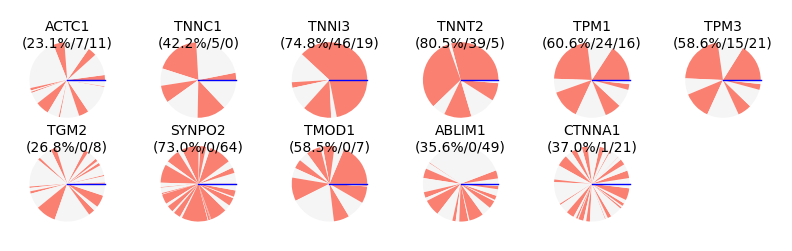

In [99]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
#plt.rcParams['axes.titlex'] = 0.1    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -5  # pad is in points...
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in thinData.items():
    k += 1
    plt.subplot(3,6,k)
    plotPieChart(thinData[i],i)
plt.subplots_adjust(wspace=0.1,hspace=0.1)

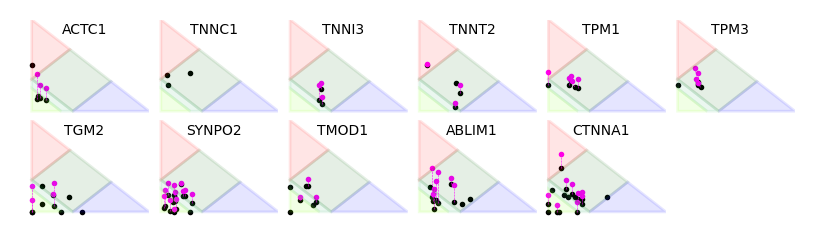

In [105]:
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in thinPappu.items():
    k += 1
    plt.subplot(3,6,k)
    plotPappus(thinPappu[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

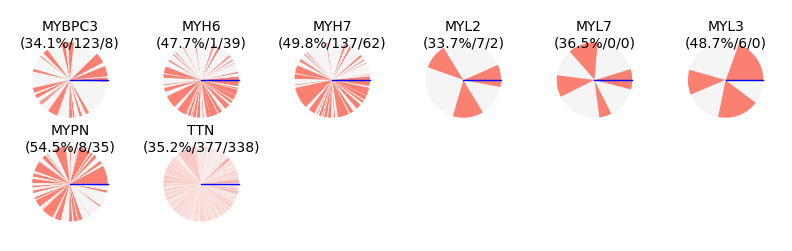

In [106]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
#plt.rcParams['axes.titlex'] = 0.1    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -5  # pad is in points...
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in thickData.items():
    k += 1
    plt.subplot(3,6,k)
    plotPieChart(thickData[i],i)
plt.subplots_adjust(wspace=0.1,hspace=0.1)

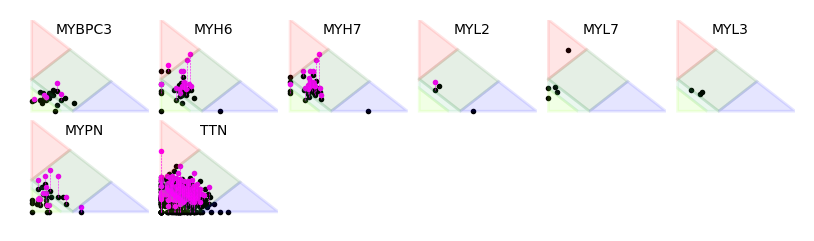

In [107]:
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in thickPappu.items():
    k += 1
    plt.subplot(3,6,k)
    plotPappus(thickPappu[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

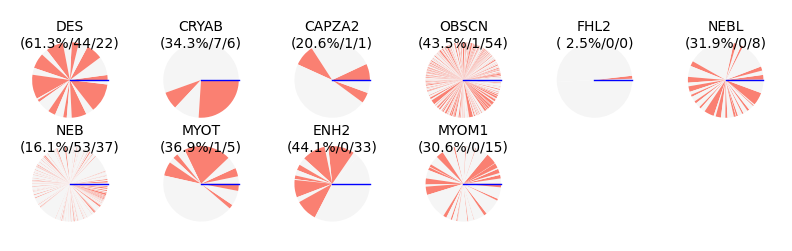

In [109]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
#plt.rcParams['axes.titlex'] = 0.1    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -5  # pad is in points...
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in zdiskData.items():
    k += 1
    plt.subplot(3,6,k)
    plotPieChart(zdiskData[i],i)
plt.subplots_adjust(wspace=0.1,hspace=0.1)

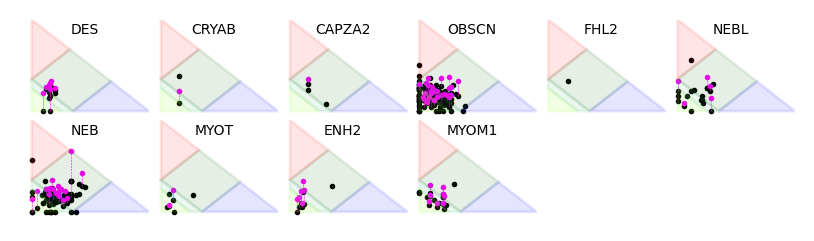

In [108]:
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in zdiskPappu.items():
    k += 1
    plt.subplot(3,6,k)
    plotPappus(zdiskPappu[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

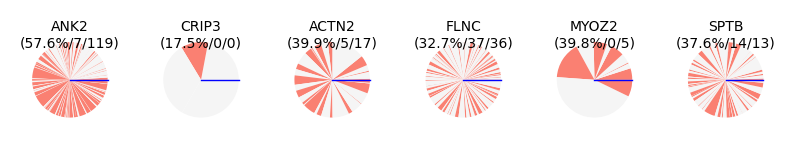

In [111]:
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
#plt.rcParams['axes.titlex'] = 0.1    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -5  # pad is in points...
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in actinCrossData.items():
    k += 1
    plt.subplot(3,6,k)
    plotPieChart(actinCrossData[i],i)
plt.subplots_adjust(wspace=0.1,hspace=0.1)

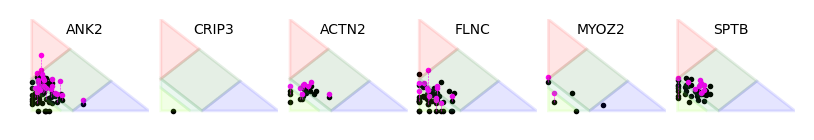

In [112]:
plt.figure(figsize=(5,2),dpi=200)
k=0
for i,j in actinCrossPappu.items():
    k += 1
    plt.subplot(3,6,k)
    plotPappus(actinCrossPappu[i],i)
plt.subplots_adjust(wspace=0,hspace=0)

/tmp/ipykernel_21857/2801912085.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


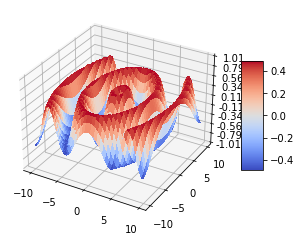

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-10, 10, 0.25)
Y = np.arange(-10, 10, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + np.random.random()*Y**2)
Z = 0.5*np.sin(1.5*R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [32]:
np.random.random()

0.3274196134594727